In [62]:
import numpy as np 
import pandas as pd 
import scipy as sp 
import matplotlib.pyplot as plt
import seaborn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
import random
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelBinarizer, StandardScaler, normalize
from sklearn.manifold import TSNE

%matplotlib inline
plt.rcParams['figure.figsize'] = 15,  8

# unzip new data

In [26]:
import zipfile
zip_ref = zipfile.ZipFile('data/numerai_datasets.zip', 'r')
zip_ref.extractall('data/')
zip_ref.close()

# Split data

In [60]:
data = pd.read_csv('data/numerai_training_data.csv')
val_data = pd.read_csv('data/numerai_tournament_data.csv')


In [85]:
data.feature1.std()

0.090129541649362058

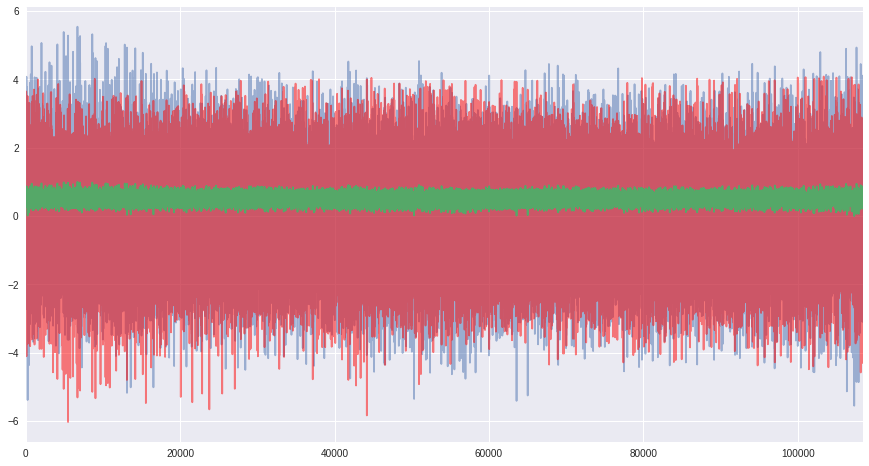

In [92]:
plt.plot((data.feature1 - data.feature1.mean() )/ data.feature1.std(), alpha = 0.5)
plt.plot((data.feature3 - data.feature3.mean() )/ data.feature3.std(), color='red',alpha = 0.5)

data.feature1.plot()

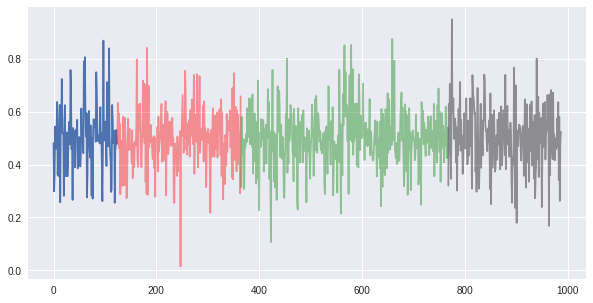

In [29]:
plt.plot(data[data.era == 'era1'].feature1)
plt.plot(data[data.era == 'era2'].feature1, 'red', alpha=.4)
plt.plot(data[data.era == 'era3'].feature1, 'green', alpha=.4
plt.plot(data[data.era == 'era4'].feature1, 'black', alpha=.4)

In [33]:
model = TSNE(n_components=2, random_state=0, perplexity=30, init='pca')
x_tsne = model.fit_transform(data.iloc[:10000, 3:-1])


In [4]:
X_val = val_data.loc[val_data.data_type == 'validation', :].iloc[:, 3:-1]
y_val = np.array(val_data.loc[val_data.data_type == 'validation', :].iloc[:, -1].values, dtype=int)

In [5]:
X_prediction = val_data.iloc[:, 3:-1]

In [6]:
# X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 3:-1], data.iloc[:, -1])
X_train = data.iloc[:, 3:-1]
y_train = np.array(data.iloc[:, -1], dtype=int)

# Adding validation data to training data 

In [7]:
X_comb = pd.concat([X_train, X_val])
y_comb = np.concatenate([y_train, y_val])

sd = StandardScaler()
X_comb = pd.DataFrame(sd.fit_transform(X_comb))

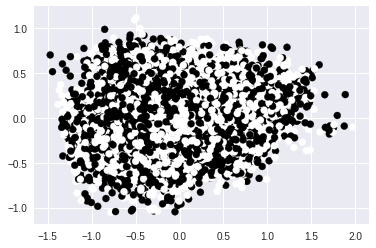

In [8]:
from sklearn.decomposition import PCA

pca = PCA()
a = pca.fit(X_train)
b = pca.fit_transform(X_train)
plt.scatter(b[:, 0], b[:, 1], c=y_train)

In [9]:
from sklearn.decomposition import PCA

pca = PCA()
a1 = pca.fit(X_prediction)
b1 = pca.fit_transform(X_prediction)

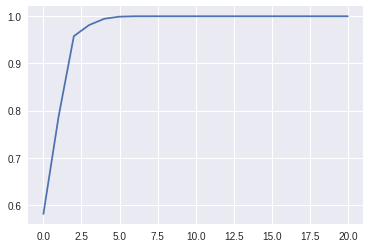

In [10]:
c = np.cumsum(a.explained_variance_ratio_)
plt.plot(range(len(c)), c)

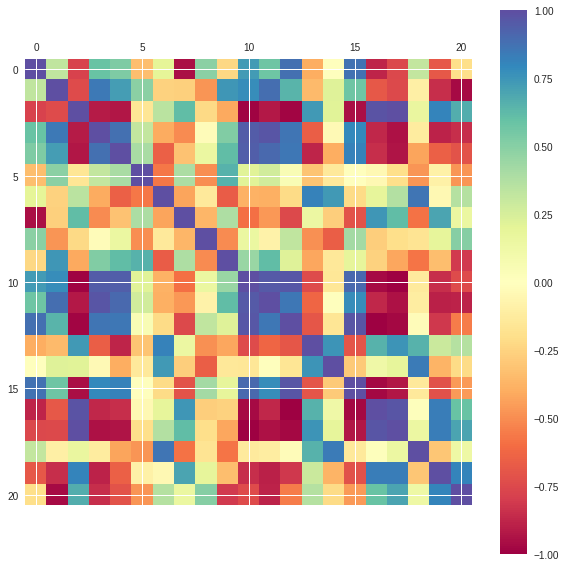

In [11]:
corr = X_train.corr()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr, vmin=-1, vmax=1, cmap=plt.cm.Spectral)
fig.colorbar(cax)


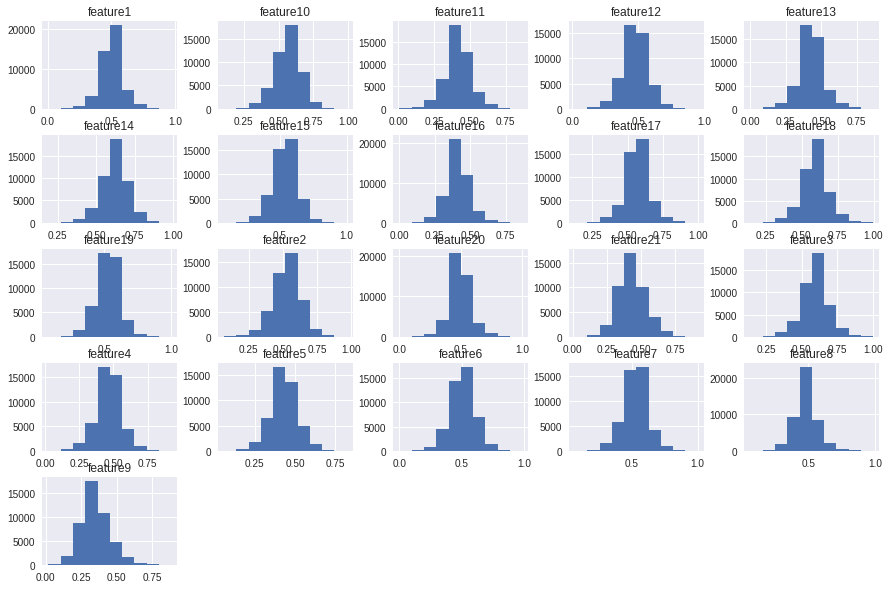

In [12]:
a = X_prediction.hist(figsize=(15,10))

# playing with eras

# Over-sampling

In [14]:
X = data.drop(['era', 'data_type'], axis=1)
Y = data.era.values
sm = SMOTE(random_state=42, )
X_res, y_res = sm.fit_sample(X, Y)

/home/mfc/.virtualenvs/py3.5/lib/python3.5/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


In [15]:
res_df = pd.DataFrame(X_res, columns=X.columns)
sd = StandardScaler()
res_feature = sd.fit_transform(res_df.iloc[:, 1:-1])
res_label = np.array(res_df.iloc[:, -1], dtype=int)

# training model utilities

In [16]:
def test_clf(grid_search, features, labels, parameters, iterations=100):
    from sklearn.metrics import classification_report
    precision, recall = [], []
    for iteration in range(iterations):
        features_train, features_test, labels_train, labels_test = train_test_split(features, labels, random_state=iteration)
        grid_search.fit(features_train, labels_train)
        predictions = grid_search.predict_proba(features_test)
    print(log_loss(labels_test, predictions[:, 1]))
    best_params = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print('%s=%r, ' % (param_name, best_params[param_name]))

In [17]:
# evalute classifier accuracy 

def clf_eval(clf, X_test, y_test, X_val, y_val):
    y_pred = clf.predict_proba(X_test)[:, 1]
#     precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
    loss = log_loss(y_test, y_pred)
    print('Test set')
    print('logloss: {}'.format(loss))
#     print('precision \t recall \t fscore \t support \n' +
#           '{} \t {} \t {} \t  {} \n'.format(precision[0], recall[0], fscore[0], support[0]) + 
#           '{} \t {} \t {} \t  {}'.format(precision[1], recall[1], fscore[1], support[1]))
    
    y_pred = clf.predict_proba(X_val)[:, 1]
    loss = log_loss(y_val, y_pred)

#     precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_pred)
    print('\n Validation set')
    print('logloss: {}'.format(loss))
#     print('precision \t recall \t fscore \t support \n' +
#           '{} \t {} \t {} \t  {} \n'.format(precision[0], recall[0], fscore[0], support[0]) + 
#           '{} \t {} \t {} \t  {}'.format(precision[1], recall[1], fscore[1], support[1]))   

# Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier

clf1 = DecisionTreeClassifier(random_state=0)
clf1.fit(res_feature, np.array(res_label, dtype=int))

clf_eval(clf1, X_train, y_train, X_val, y_val)

Test set
logloss: 17.18799174918163

 Validation set
logloss: 17.391843827013144


# Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

clf2 = RandomForestClassifier(n_jobs=-1)

parameters = {'n_estimators': [60],
              'criterion': ['gini', 'entropy'],
              'max_depth': [3, 5, 10],
              'min_samples_split': [10, 15], 
              'min_impurity_split' : [1e-7,1e-5]}

grid_search2 = GridSearchCV(clf2, parameters)

test_clf(grid_search2, b[:, :5], y_comb, parameters, iterations=1)

ValueError: Found input variables with inconsistent numbers of samples: [108405, 125091]

# Gradient Booting Trees

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()

parameters = {'n_estimators': [10, 20, 30, 40],
              'criterion': ['gini'],
              'max_depth': [5, 10, 20],
              'min_samples_split': [2, 5, 10], 
              'min_impurity_split' : [1e-7,1e-15]}
# 
grid_search3= GridSearchCV(clf, parameters)

test_clf(grid_search3, res_feature, res_label, parameters, iterations=1)

# clf_eval(clf, X_test, y_test, X_val, y_val)

KeyError: 'gini'

# Xgboost

In [24]:
import xgboost as xgb
from sklearn.cross_validation import StratifiedKFold


dtrain = xgb.DMatrix(data=res_feature, label=res_label)
dtest = xgb.DMatrix(data=sd.fit_transform(X_val), label=y_val)

gbm = xgb.XGBClassifier()
gbm_params = {
    'learning_rate': [0.05],
    'n_estimators': [1000],
    'max_depth': [2, 3, 10],
}
cv = StratifiedKFold(res_label)
grid = GridSearchCV(gbm, gbm_params,scoring='neg_log_loss',cv=cv,verbose=10)
grid.fit(res_feature, res_label)

ImportError: No module named 'xgboost'

In [120]:
preds = grid.predict_proba(sd.fit_transform(X_prediction))

# print('-'* 10 + ' \n logloss: {}'.format(log_loss(res_label, preds)))

#  Voting Classifier

In [126]:
clf1 = LogisticRegression(random_state=2)
clf2 = grid_search2.best_estimator_
clf3 = GaussianNB()
# clf4 = grid_search3.best_estimator_
clf5 = grid.best_estimator_
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('xgb', clf5)], voting='soft')
# eclf = VotingClassifier(estimators=[('rf', clf2)], voting='soft')
# eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')


clf1.fit(b[:, :5], y_comb)
clf2.fit(b[:, :5], y_comb)
clf3.fit(b[:, :5], y_comb)
# clf4.fit(b[:, :5], y_comb)
clf5.fit(b[:, :5], y_comb)
eclf.fit(b[:, :5], y_comb)
print(log_loss(y_comb, eclf.predict_proba(b[:, :5])[:,1]))

0.691045963808


# Neural nets

In [25]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
a = enc.fit_transform(y_train)


In [26]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import metrics
from keras import optimizers

model = Sequential()

model.add(Dense(units=128, input_dim=21))
model.add(Activation('tanh'))
model.add(Dense(units=128))
model.add(Activation('tanh'))
model.add(Dense(units=64))
model.add(Dense(units=64))
model.add(Dense(units=2))
# model.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
adagrad = optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
adamax = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.001)


def lss(y_true, y_pred):
    return log_loss(y_true, y_pred)

model.compile(loss='binary_crossentropy',
              optimizer=rmsprop,
              metrics=['acc'])

model.fit(res_feature, res_label, epochs=100, batch_size=4096, validation_split=0.1)

ImportError: No module named 'keras'

In [ ]:
probability = model.predict_proba(sd.fit_transform(X_val))
log_loss(y_val, probability.reshape(probability.shape[0]))

# make submission 

In [127]:
# probability = grid_search2.predict_proba(sd.fit_transform(X_prediction))[:, 1]
probability = eclf.predict_proba(b1[:, :5])[:, 1]
# probability = model.predict_proba(sd.fit_transform(X_prediction))
# probability = probability.reshape(probability.shape[0])
# probability += np.random.randn(probability.shape[0]) * 0.01
submit = pd.DataFrame({'id':val_data.id.values, 'probability': preds[:, 1]})
submit.to_csv('submit.csv', index=False)